## Image Classification with CNN for Malaria Data

In this project, we have a malaria dataset. I solved this project using colab notebook on kaggle.


This is an image classification project solved with a cnn (convolutional neural network).

1)Dataset: The malaria dataset consists of microscopic blood smear images belonging to two classes: Uninfected and Parasitized. It contains hundreds of images for each class.

2)Data Preparation:
The image data is loaded from the cell_images directory.
The training and validation data are generated using the ImageDataGenerator, with 20% of the data set aside for validation.

3)Model Definition:
The VGG16 architecture is used as the base model.
The final fully connected layers of the VGG16 model are removed, and it is used as a feature extractor.
The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy metric.

4)Model Training:
The prepared training and validation data generators are used to train the model for 15 epochs.
In summary, the code sets up a transfer learning-based deep learning model for classifying malaria cell images and trains it.

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240810%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240810T204239Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64d0effb8a57c89bd8c149f71ac8ab93dff6f8d3008aedfd4138442e0b165c936374de742c0ba3173f7436da9bbe3ebdfd0cd63ac793ea132c251e46f3a353ff3bf875ba47c639e7175ea28b4b9f3c89ead67b1c6346f9d7a9679eb2e2381e919918d10ad1cd6e4420060e6e0251908b014f211eab659b49e85276b18b0a3529764540c83e0377cbab4729371f1e2c56e74e3cb5ddd16db9aaa49372569867e5ce86cbfaebd0f5c091c12f6dd60df401bb230d0ca7e4cbcefd9eb5e5c5097a2d8b90adcb9b345ea932023f49962aaaaeb4c2f3e4588620c934bb7e2a757982d6cee95ec825863fec43bd447a3102a0bc307c15d61662930c2a0d4aa4afe02424'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, Reshape, MaxPooling2D, Flatten, Dropout, BatchNormalization
import cv2
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from IPython.display import Image
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Görüntülenen çıkış son 5000 satıra kısaltıldı.
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C216ThinF_IMG_20151106_135337_cell_145.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C125P86ThinF_IMG_20151004_102013_cell_37.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C142P103ThinF_IMG_20151005_222255_cell_29.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C182P143NThinF_IMG_20151201_171836_cell_16.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C127P88ThinF_IMG_20151004_111651_cell_68.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C186P147NThinF_IMG_20151203_150322_cell_110.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C201ThinF_IMG_20150930_142848_cell_106.png
/kaggle/input/cell-images-for-detecting-malaria/cell_im

In [ ]:
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/"))

['Parasitized', 'Uninfected']


## Different Ways to Display Images

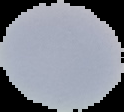

In [ ]:
input=cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C181P142ThinF_IMG_20151127_160539_cell_155.png')
cv2_imshow(input)
#Uninfected Cell

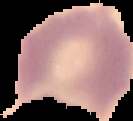

In [ ]:
Image('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C33P1thinF_IMG_20150619_121300a_cell_46.png')
#Uninfected cell

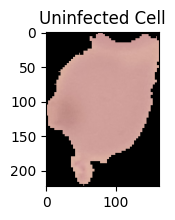

In [ ]:
u='/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C69P30N_ThinF_IMG_20150819_140652_cell_126.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(u))
plt.title('Uninfected Cell')
plt.show()

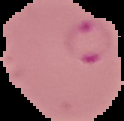

In [ ]:
input=cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C136P97ThinF_IMG_20151005_141946_cell_114.png')
cv2_imshow(input)
#Parasizited Cell

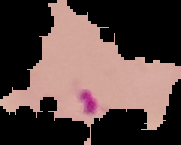

In [ ]:
Image('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C91P52ThinF_IMG_20150821_125256_cell_8.png')
#Parasizited cell

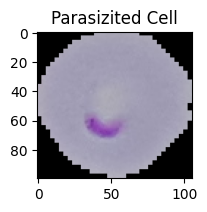

In [ ]:
p='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C182P143NThinF_IMG_20151201_171905_cell_138.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('Parasizited Cell')
plt.show()

##Image Classification using Transfer Learning with VGG16

In [ ]:
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/'
img_width, img_height = 32, 32
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_datagenerator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_width, img_height),
    class_mode='binary',
    subset='training'
)

test_datagenerator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_width, img_height),
    class_mode='binary',
    subset='validation'
)

base_model = VGG16(weights='imagenet', include_top=False)

model = Sequential()
model.add(base_model)

for layer in base_model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_datagenerator, epochs=15, validation_data=test_datagenerator,verbose=1)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 241s 344ms/step - accuracy: 0.8266 - loss: 0.3871 - val_accuracy: 0.8541 - val_loss: 0.3262
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 230s 334ms/step - accuracy: 0.8713 - loss: 0.2999 - val_accuracy: 0.8770 - val_loss: 0.3003
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 262s 334ms/step - accuracy: 0.8777 - loss: 0.2888 - val_accuracy: 0.8633 - val_loss: 0.3107
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 262s 334ms/step - accuracy: 0.8763 - loss: 0.2889 - val_accuracy: 0.8691 - val_loss: 0.3001
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 261s 333ms/step - accuracy: 0.8852 - loss: 0.2734 - val_accuracy: 0.8789 - val_loss: 0.2857
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 231s 336ms/step - accuracy: 0.8874 - loss: 0.2668 - val_accuracy: 0.8817 - val_loss: 0.2824
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 231s 335ms/step - accuracy: 0.8873 - loss: 0.2618 - val_accuracy: 0.8835 - val_loss: 0.2766
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 263s 337ms/step - accuracy: 0.8898 - loss: 0.25

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,293,701 (62.16 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [ ]:
pred_x = model.predict(test_datagenerator)
class_x = np.argmax(pred_x, axis=1)

y_true = test_datagenerator.classes

class_names = test_datagenerator.class_indices
class_labels = list(class_names.keys())


173/173 ━━━━━━━━━━━━━━━━━━━━ 60s 344ms/step


In [ ]:
print(classification_report(y_true, class_x, target_names=class_labels))

              precision    recall  f1-score   support

 Parasitized       0.50      1.00      0.67      2755
  Uninfected       0.00      0.00      0.00      2755

    accuracy                           0.50      5510
   macro avg       0.25      0.50      0.33      5510
weighted avg       0.25      0.50      0.33      5510



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(y_true, class_x)

array([[2755,    0],
       [2755,    0]])

In [ ]:
model.save('malaria_vgg16.keras')
#I saved the model with h5 at first.But it turned out that this was an old recording method, keras was newer.I also saved it as keras.

We trained our data using transfer learning. We achieved a success rate of approximately 90 percent for the train data and approximately 88 percent for the test. Our model was trained successfully. We looked at the confusion matrix and classification report. We saved our model for later use.